In [1]:
from importlib import reload
from rlxutils import subplots
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import os

import omegaconf
from loguru import logger
from omegaconf import DictConfig, OmegaConf
import hydra
from progressbar import progressbar as pbar

from earthtext.search import search
from earthtext.datamodules.components import chipmultilabel
from earthtext.osm.multilabel import kvmerged
from joblib import Parallel, delayed
from importlib import reload
reload(chipmultilabel)
reload(search)

<module 'earthtext.search.search' from '/home/ubuntu/earth-text/src/earthtext/search/search.py'>

# setup

- copy `s3://clay-text/models/` into `/opt/data/models`
- copy `s3://clay-text/california-worldcover-chips` into `/opt/data/california-worldcover-chips`
- copy `s3://clay-california-worldcover-rgbnir-vvvh-chips/chips/` into `/opt/data/clay-california-worldcover-rgbnir-vvvh-chips/chips`

double check for the locations on the dataloader configuration below

    metadata_file             /opt/data/california-worldcover-chips/california-worldcover-chips-osm-multilabels.parquet
    embeddings_folder         /opt/data/california-worldcover-chips/embeddings_v0.2
    chips_folder              /opt/data/clay-california-worldcover-rgbnir-vvvh-chips/chips


    !ls /opt/data/models/osm*
    /opt/data/models/osm_emcoder_2024-04-25_12:01.ckpt
    /opt/data/models/osm_emcoder_2024-04-25_12:01.yaml

# load an initialize searcher object

- `search_target` can be `train`, `test` or `val`

In [19]:
reload(search)
model_ckpt_fname = "/opt/data/models//osm_emcoder__embeddings_v0.2-20240426__trainedon_2024-05-05_00:45.ckpt"

searcher = search.OSMClayModelSearcher(model_ckpt_fname, search_target='train')

2024-05-05 00:47:01.139 | INFO     | earthtext.search.search:__init__:76 - search target is 'train'


In [20]:
print ("dataloader configuration\n")
for k,v in searcher.conf.dataloader.items():
    print (f"{k:25s} {v}")

dataloader configuration

_target_                  earthtext.datamodules.chipmultilabel.ChipMultilabelModule
metadata_file             /opt/data/california-worldcover-chips/california-worldcover-chips-osm-multilabels.parquet
embeddings_folder         /opt/data/california-worldcover-chips/embeddings_v0.2-20240426
chips_folder              /opt/data/clay-california-worldcover-rgbnir-vvvh-chips/chips
get_osm_strlabels         True
get_osm_ohearea           True
get_osm_ohecount          True
get_osm_ohelength         True
embeddings_normalization  mean_stdev_norm
multilabel_threshold_osm_ohecount 1
normalize_input           True
batch_size                32


In [21]:
print ("model configuration\n")
for k,v in searcher.conf.model.items():
    print (f"{k:25s} {v}")

model configuration

_target_                  earthtext.models.osmencoder.OSMEncoder
output_dim                768
layers_spec               [512, 1024, 2048]
use_osm_counts            True
use_osm_lengths           True
osm_tags_indexes          [2, 3, 4, 5, 6, 7, 8, 13, 14, 18, 23, 30, 33, 37, 43, 58, 61, 68, 71, 84, 93]
activation_fn             relu


In [22]:
searcher.setup()

2024-05-05 00:47:04.190 | INFO     | earthtext.search.search:setup:115 - loading model
2024-05-05 00:47:04.226 | INFO     | earthtext.search.search:setup:119 - initializing dataloaders
2024-05-05 00:47:04.930 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:93 - checking chip files for train split
100% (60396 of 60396) |##################| Elapsed Time: 0:00:03 Time:  0:00:030000
2024-05-05 00:47:07.986 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:97 - read train split with 60295 chip files (out of 60396)
2024-05-05 00:47:07.987 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:102 - max cache size is -1
2024-05-05 00:47:08.666 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:93 - checking chip files for val split
100% (12304 of 12304) |##################| Elapsed Time: 0:00:00 Time:  0:00:000000
2024-05-05 00:47:09.304 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:97 - read v

# build the object for autocompletion

it's ok if you get and error like `AssertionError: can only test a child process`, it seems torch dataloaders take care of it

In [23]:
ts = search.QueryAutocompletionSampler(searcher, query_source='train')

2024-05-05 00:47:38.176 | INFO     | earthtext.search.search:__init__:159 - search target is train, query source is train
2024-05-05 00:47:38.177 | INFO     | earthtext.search.search:__init__:163 - loading all samples from query source
100% (1885 of 1885) |####################| Elapsed Time: 0:00:15 Time:  0:00:150001


# define a user query

In [24]:
# select from these tags
searcher.model.osm_tags_names

array(['building=*', 'building=apartments', 'building=house',
       'building=industrial', 'building=residential', 'building=school',
       'building=warehouse', 'highway=*', 'highway=track',
       'landuse=commercial', 'landuse=grass', 'landuse=residential',
       'leisure=*', 'leisure=park', 'natural=*', 'natural=water',
       'parking=*', 'sport=*', 'sport=baseball', 'water=*', 'waterway=*'],
      dtype='<U20')

In [8]:
chipm2 = 256*256*100 # how many square meters in a chip

In [25]:
# i want chips with at least 5 baseball fields and no buildings
min_counts, max_counts = {'sport=baseball':5 }, {'building=*': 0}
min_areas,  max_areas  = {}, {}

# i want at least 10 parkings and no highways --> only one sample returned for autocompletion
min_counts, max_counts = {'parking=*':10}, {'highway=*': 0}
min_areas,  max_areas  = {}, {}

# i want chips at least covered 50% with farmland and with no buildings
min_counts, max_counts = {}, {} 
min_areas,  max_areas = {'landuse=farmland':.50*chipm2}, {'building=*': 0}

# i want chips at least covered 10% with industrial and at most 10% with farmland
min_counts, max_counts = {}, {} 
min_areas,  max_areas = {'landuse=industrial':.1*chipm2}, {'landuse=farmland': .1*chipm2}

# i want chips at least covered 10% with lakes and .1% with buildings
min_counts, max_counts = {}, {}
min_areas, max_areas   = {'water=*': .1*chipm2, 'building=*':.001*chipm2}, {}

# i want between 1 and 10 buildings, with water=lake of at least 1% of the chips surface area
min_counts, max_counts = {'building=*': 1}, { 'building=*': 10}
min_areas,  max_areas  = {'water=*': .01*chipm2} ,{}


# autocomplete the query by sampling osm vectors that comply with the user query


In [26]:
# autocomplete the query by sampling osm vectors that comply with the user query
q = ts.sample_queries_with_conditions( min_counts = min_counts, max_counts = max_counts, 
                                       min_areas = min_areas, max_areas = max_areas,
                                       n_samples=10)
print (f"sampled {len(q['indexes'])} osm vectors complying with the user query")

sampled 10 osm vectors complying with the user query


# inspect the sampled chips with which the user query has been autocompleted

min areas and min counts


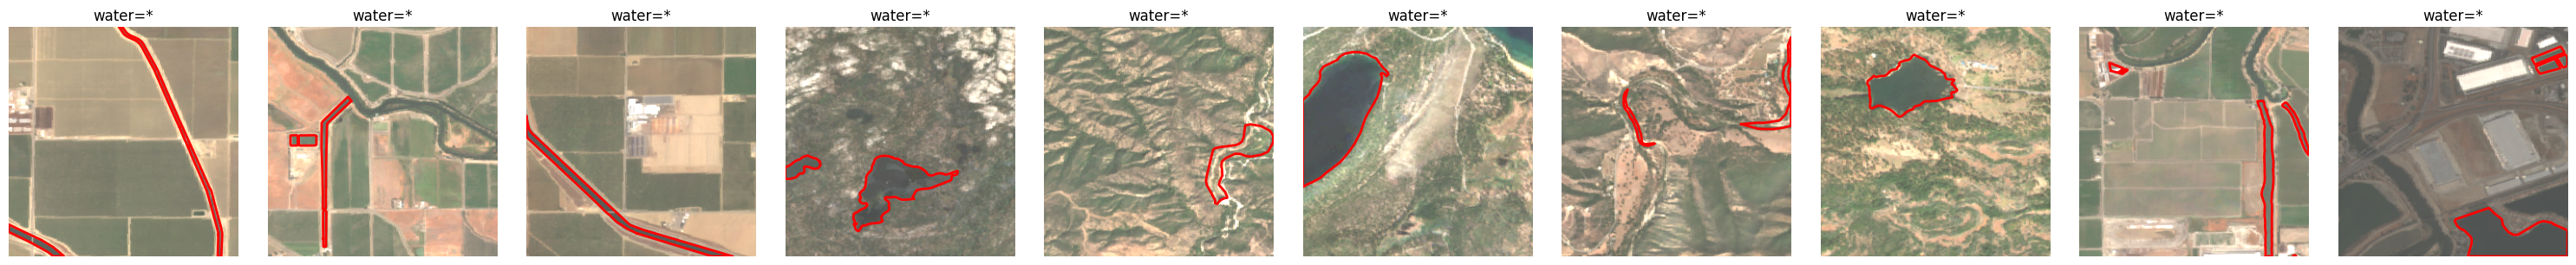

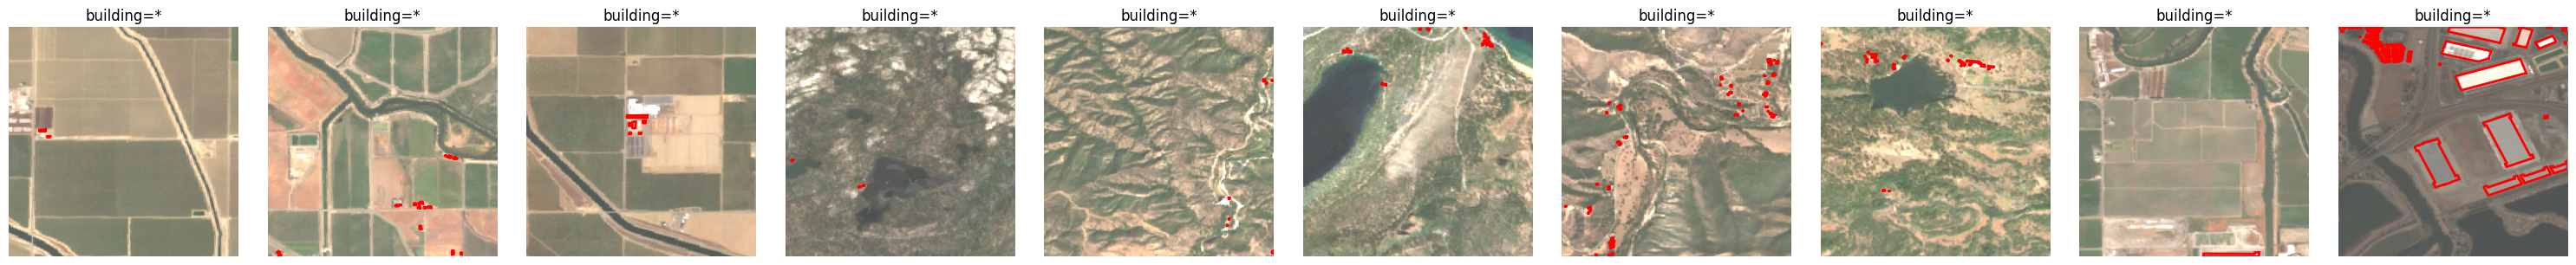

In [27]:
ts.query_dataloader.dataset.disable_chip_loading = False
ts.query_dataloader.dataset.reset_cache()

for tag in list(min_areas.keys()) + list(min_counts.keys()):
    for ax,qi in subplots(len(q['indexes'])):
        ts.query_dataloader.dataset.plot_chip_with_tags(q['indexes'][qi], [tag])
        plt.title(tag)
print("min areas and min counts")

# build the osm vector for which to predict clay embeddings

mode can be

- `sample_autocompleted`: one random osm vector is selected from above
- `average_autocompleted`: the above osm vectors are averaged

note that the `osmencoder` expects osmvectors normalized (counts, areas and lengths substracted the distribution mean and divided by their stdev), so `query_osmvector` is normalized. we also store `query_original_osmcount` for visualization purposes only

In [28]:
mode = "average_autocompleted"
#mode = "sample_autocompleted"


In [29]:
if mode == "sample_autocompleted":
    qi = np.random.randint(len(q['indexes']))
    query_osmvector = {k:v[qi].reshape(1,-1) for k,v in q['normalized_query_vector'].items()}
    query_original_osmcount = q['original_query_vector']['osm_ohecount'][qi]

elif mode == 'average_autocompleted':
    query_osmvector = {k:v.mean(axis=0).reshape(1,-1) for k,v in q['normalized_query_vector'].items()}
    query_original_osmcount = q['original_query_vector']['osm_ohecount'].mean(axis=1)

# use the osmencoder to predict the clay embeddings

In [30]:
p = searcher.predict_embeddings(query_osmvector)[0]
p.shape


torch.Size([768])

# search for similar embeddings

- use `topn` to control how many results you get

In [31]:
r = searcher.make_search(p, topn=10)
print ("search results structure\n")

for k,v in r.items():
    if isinstance(v, np.ndarray):
        print (f"{k:10s}           {v.shape}")
    elif isinstance(v, dict):
        print (k)
        for kk,vv in v.items():
            print (f"     {kk:15s} {vv.shape}")            
        


search results structure

chip_ids             (10,)
normalized_osm_vectors
     osm_ohecount    (10, 99)
     osm_ohearea     (10, 99)
     osm_ohelength   (10, 99)
embeddings           (10, 768)
original_osm_vectors
     osm_ohecount    (10, 99)
     osm_ohearea     (10, 99)
     osm_ohelength   (10, 99)
idxs                 (10,)
scores               (10,)


# inspect search results

osm tags are painted in red only for validation purposes, those should not be available in a production environment

In [32]:
ds = searcher.get_search_dataset()
ds.disable_chip_loading = False
ds.reset_cache()


TAGS for min areas and min counts


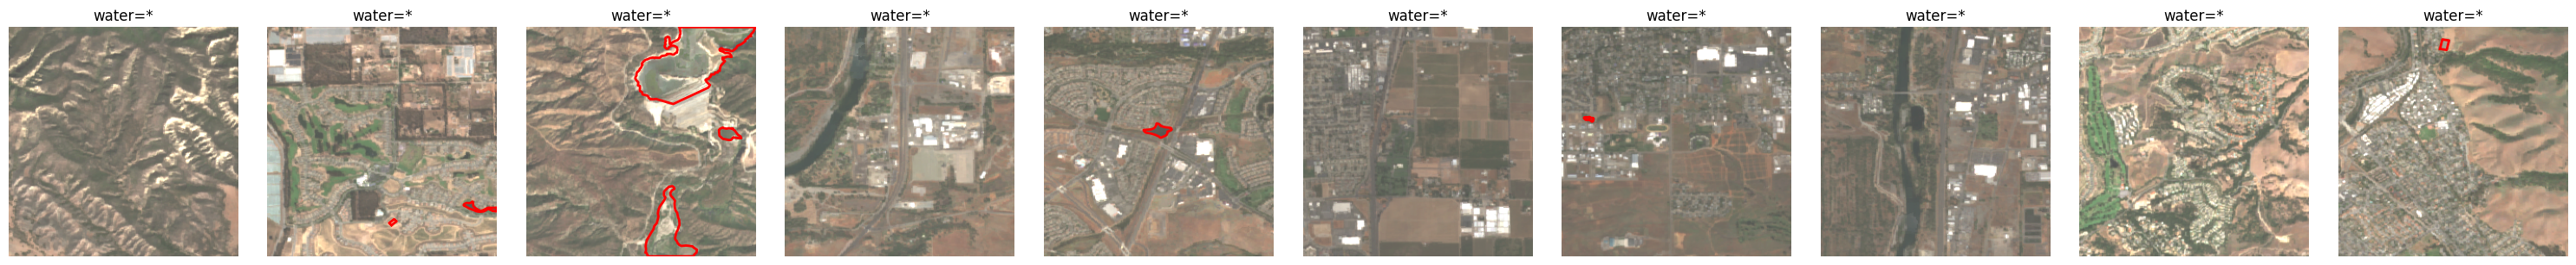

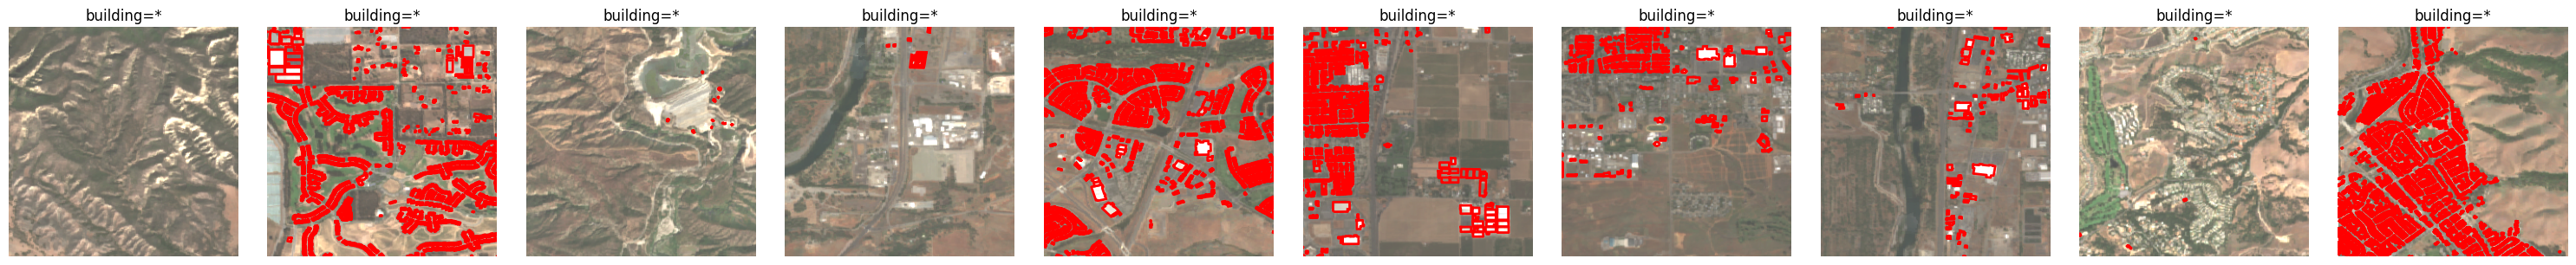

In [33]:
for tag in list(min_areas.keys()) + list(min_counts.keys()):
    for ax, i in subplots(len(r['idxs'])):
        ds.plot_chip_with_tags(r['idxs'][i],  [tag])
        plt.title(tag)
print ("TAGS for min areas and min counts")

TAGS for max areas and ax counts


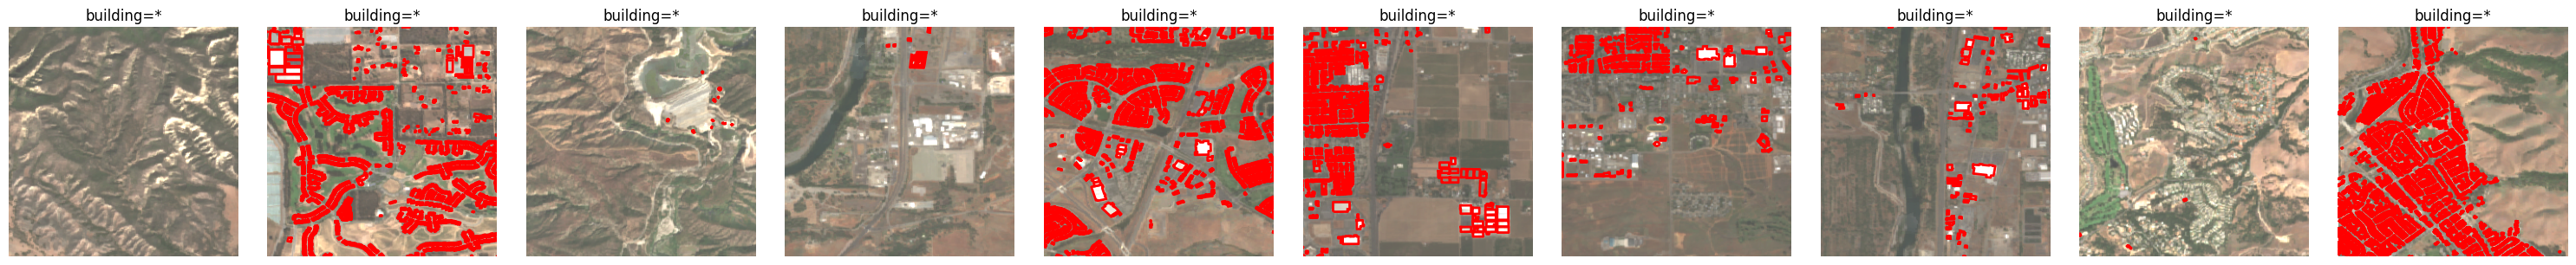

In [34]:
for tag in list(max_areas.keys()) + list(max_counts.keys()):
    for ax, i in subplots(len(r['idxs'])):
        ds.plot_chip_with_tags(r['idxs'][i],  [tag])
        plt.title(tag)
print ("TAGS for max areas and ax counts")